# SQL Magics (Pyspark + Iceberg)

In [1]:
import duckdb
import pandas as pd
import matplotlib

In [2]:
%%sql
CREATE DATABASE IF NOT EXISTS hive.nyc;

++
||
++
++

In [3]:
%%sql
CREATE TABLE IF NOT EXISTS hive.nyc.taxis (
    VendorID              bigint,


    tpep_pickup_datetime  timestamp,
    tpep_dropoff_datetime timestamp,
    passenger_count       double,
    trip_distance         double,
    RatecodeID            double,
    store_and_fwd_flag    string,
    PULocationID          bigint,
    DOLocationID          bigint,
    payment_type          bigint,
    fare_amount           double,
    extra                 double,
    mta_tax               double,
    tip_amount            double,
    tolls_amount          double,
    improvement_surcharge double,
    total_amount          double,
    congestion_surcharge  double,
    airport_fee           double
)
USING iceberg
PARTITIONED BY (days(tpep_pickup_datetime))


++
||
++
++

In [4]:
# https://github.com/toddwschneider/nyc-taxi-data/blob/master/setup_files/raw_data_urls.txt
# %cd work
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-12.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-03.parquet

[Errno 2] No such file or directory: 'work'
/home/jovyan/notebooks
--2023-12-10 09:33:33--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-12.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.226.161, 3.160.226.228, 3.160.226.111, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.160.226.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49639052 (47M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2021-12.parquet’

yellow_tripdata_202 100%[===================>]  47.34M  31.7MB/s    in 1.5s    

2023-12-10 09:33:35 (31.7 MB/s) - ‘yellow_tripdata_2021-12.parquet’ saved [49639052/49639052]

--2023-12-10 09:33:36--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.226.161, 3.160.226.228, 3.160.226.111, ...
Connecting to d37ci6vzurychx.cloudfron

In [4]:
from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Jupyter").getOrCreate()
spark = SparkSession.builder.appName("Jupyter")\
    .config("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.13:1.4.2,org.duckdb:duckdb_jdbc:0.9.2")\
    .config("spark.hadoop.datanucleus.schema.autoCreateTables","true")\
    .config("spark.hadoop.datanucleus.schema.autoCreateSchema","true")\
    .config("spark.sql.catalog.hive","org.apache.iceberg.spark.SparkCatalog")\
    .config("spark.sql.catalog.hive.uri","thrift://metastore:9083")\
    .config("spark.sql.catalog.hive.type","hadoop")\
    .config("spark.sql.catalog.hive.warehouse","/home/jovyan/spark-datawarehouse")\
    .getOrCreate()

for filename in [
    "yellow_tripdata_2022-03.parquet",
    "yellow_tripdata_2022-02.parquet",
    "yellow_tripdata_2022-01.parquet",
    "yellow_tripdata_2021-12.parquet",
]:
    df = spark.read.parquet(f"{filename}").sortWithinPartitions("tpep_pickup_datetime")
    df.write.mode("append").saveAsTable("hive.nyc.taxis")


In [5]:
df = spark.sql("select * from hive.nyc.taxis")
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2022-03-16 00:01:34|  2022-03-16 00:30:47|            1.0|         6.81|       1.0|                 N|         114|          75|           1|       24.0|  0.5|    0.5|      5.5

In [6]:
%%sql
select * from hive.nyc.taxis limit 10

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2,2003-01-05 04:05:18,2003-01-05 18:41:11,1.0,0.0,1.0,N,193,193,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009-01-01 04:08:09,2009-01-01 04:23:06,1.0,1.63,1.0,N,186,162,2,10.5,0.5,0.5,0.0,0.0,0.3,14.3,2.5,0.0
2,2009-01-01 04:23:51,2009-01-01 21:21:05,1.0,5.55,1.0,N,233,256,1,20.0,0.5,0.5,4.76,0.0,0.3,28.56,2.5,0.0
2,2009-01-01 00:07:27,2009-01-01 18:53:33,1.0,0.0,1.0,N,193,193,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009-01-01 06:36:41,2009-01-01 14:11:14,1.0,0.69,1.0,N,263,236,1,5.5,0.0,0.5,4.0,0.0,0.3,12.8,2.5,0.0
2,2022-01-31 23:49:19,2022-02-01 00:01:32,1.0,2.47,1.0,N,143,236,1,11.0,0.5,0.5,2.96,0.0,0.3,17.76,2.5,0.0
2,2022-01-31 23:50:06,2022-01-31 23:58:51,4.0,1.52,1.0,N,229,170,2,8.0,0.5,0.5,0.0,0.0,0.3,11.8,2.5,0.0
2,2022-01-31 23:48:06,2022-01-31 23:59:09,1.0,2.67,1.0,N,100,239,1,11.0,0.5,0.5,2.96,0.0,0.3,17.76,2.5,0.0
2,2022-01-31 23:38:30,2022-01-31 23:48:13,1.0,4.78,1.0,N,41,127,1,15.0,0.5,0.5,6.0,0.0,0.3,22.3,0.0,0.0
2,2022-01-31 23:56:17,2022-02-01 00:09:08,1.0,3.55,1.0,N,79,50,1,13.0,0.5,0.5,3.36,0.0,0.3,20.16,2.5,0.0


# SQL Magics (DuckDB)

In [7]:
# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

%reload_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False


%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db
%sql SELECT 'Off and flying!' as a_duckdb_column

There's a new jupysql version available (0.10.4), you're running 0.10.1. To upgrade: pip install jupysql --upgrade
Deploy AI and data apps for free on Ploomber Cloud! Learn more: https://docs.cloud.ploomber.io/en/latest/quickstart/signup.html


,a_duckdb_column
0,Off and flying!


In [8]:
%%sql
SELECT
    schema_name,
    function_name
FROM duckdb_functions()
ORDER BY ALL DESC
LIMIT 5

,schema_name,function_name
0,pg_catalog,shobj_description
1,pg_catalog,shobj_description
2,pg_catalog,shobj_description
3,pg_catalog,pg_typeof
4,pg_catalog,pg_typeof


In [9]:
%sql my_df << SELECT 'Off and flying!' as a_duckdb_column

In [10]:


input_df = pd.DataFrame.from_dict({"i":[1, 2, 3],
                                  "j":["one", "two", "three"]})


In [11]:
%sql output_df << SELECT sum(i) as total_i FROM input_df

In [12]:
%%sql
INSTALL httpfs;
LOAD httpfs;

,Success


<Axes: title={'center': "'trip_distance' from 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet'"}, ylabel='trip_distance'>

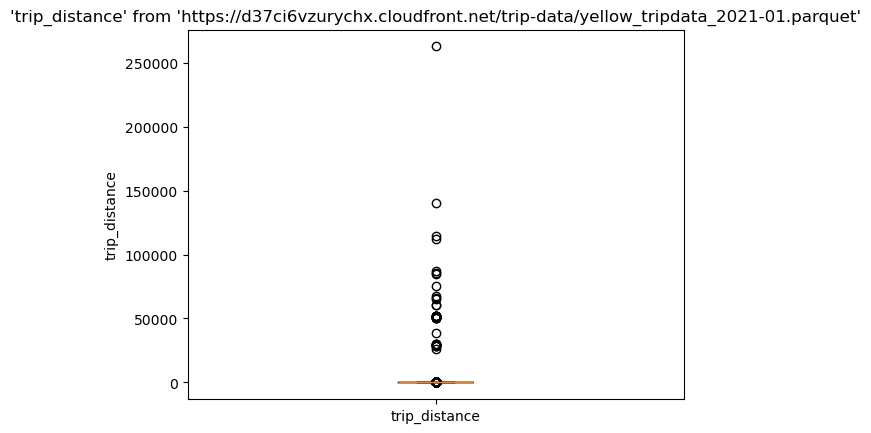

In [13]:
%sqlplot boxplot --table https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet --column trip_distance